# Global Happiness Predictions

## Introduction

Happiness depends on many things such as country’s economy, social support, and health. In this project, we look at data from different countries to see what really drives happiness. Using data analysis, machine learning, and clear visualizations, we try to understand patterns and predict how happiness might change in the future.

## Data Preprocessing

In [2]:
# Load necessary libraries
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import os
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

with warnings.catch_warnings(action="ignore"):
    fxn()

# Machine Learning libraries
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.dummy import DummyRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2

# Models
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import GradientBoostingRegressor

In [3]:
# Load the dataset
df = pd.read_csv('./dataset/dataset.csv')

# Display the first few rows of the dataset
display(df.head())

,country,region,happiness_score,gdp_per_capita,social_support,healthy_life_expectancy,freedom_to_make_life_choices,generosity,perceptions_of_corruption,year
0,Finland,Western Europe,7.804,1.888,1.585,0.535,0.772,0.126,0.535,2023
1,Denmark,Western Europe,7.586,1.949,1.548,0.537,0.734,0.208,0.525,2023
2,Iceland,Western Europe,7.530,1.926,1.620,0.559,0.738,0.250,0.187,2023
3,Israel,Middle East and North Africa,7.473,1.833,1.521,0.577,0.569,0.124,0.158,2023
4,Netherlands,Western Europe,7.403,1.942,1.488,0.545,0.672,0.251,0.394,2023


In [4]:
# Get a summary of the dataset
df.info()

# Display basic statistics of the dataset
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1367 entries, 0 to 1366
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   country                       1367 non-null   object 
 1   region                        1367 non-null   object 
 2   happiness_score               1367 non-null   float64
 3   gdp_per_capita                1367 non-null   float64
 4   social_support                1367 non-null   float64
 5   healthy_life_expectancy       1366 non-null   float64
 6   freedom_to_make_life_choices  1367 non-null   float64
 7   generosity                    1367 non-null   float64
 8   perceptions_of_corruption     1366 non-null   float64
 9   year                          1367 non-null   int64  
dtypes: float64(7), int64(1), object(2)
memory usage: 106.9+ KB


,happiness_score,gdp_per_capita,social_support,healthy_life_expectancy,freedom_to_make_life_choices,generosity,perceptions_of_corruption,year
count,1367.000000,1367.000000,1367.000000,1366.000000,1367.000000,1367.000000,1366.000000,1367.000000
mean,5.441086,1.019422,1.045334,0.584043,0.450771,0.196260,0.132275,2018.903438
std,1.117909,0.453703,0.331163,0.245117,0.156733,0.113301,0.112555,2.561006
min,1.859000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2015.000000
25%,4.599500,0.696326,0.832022,0.402301,0.356000,0.115000,0.056826,2017.000000
50%,5.440000,1.043000,1.083000,0.612830,0.467610,0.182700,0.097000,2019.000000
75%,6.256300,1.338473,1.299985,0.777614,0.568685,0.252858,0.165945,2021.000000
max,7.842000,2.209000,1.644000,1.141000,0.772000,0.838075,0.587000,2023.000000


In [5]:
# Drop rows with nulls
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1365 entries, 0 to 1366
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   country                       1365 non-null   object 
 1   region                        1365 non-null   object 
 2   happiness_score               1365 non-null   float64
 3   gdp_per_capita                1365 non-null   float64
 4   social_support                1365 non-null   float64
 5   healthy_life_expectancy       1365 non-null   float64
 6   freedom_to_make_life_choices  1365 non-null   float64
 7   generosity                    1365 non-null   float64
 8   perceptions_of_corruption     1365 non-null   float64
 9   year                          1365 non-null   int64  
dtypes: float64(7), int64(1), object(2)
memory usage: 117.3+ KB


### 1.1 Correlation Analysis 

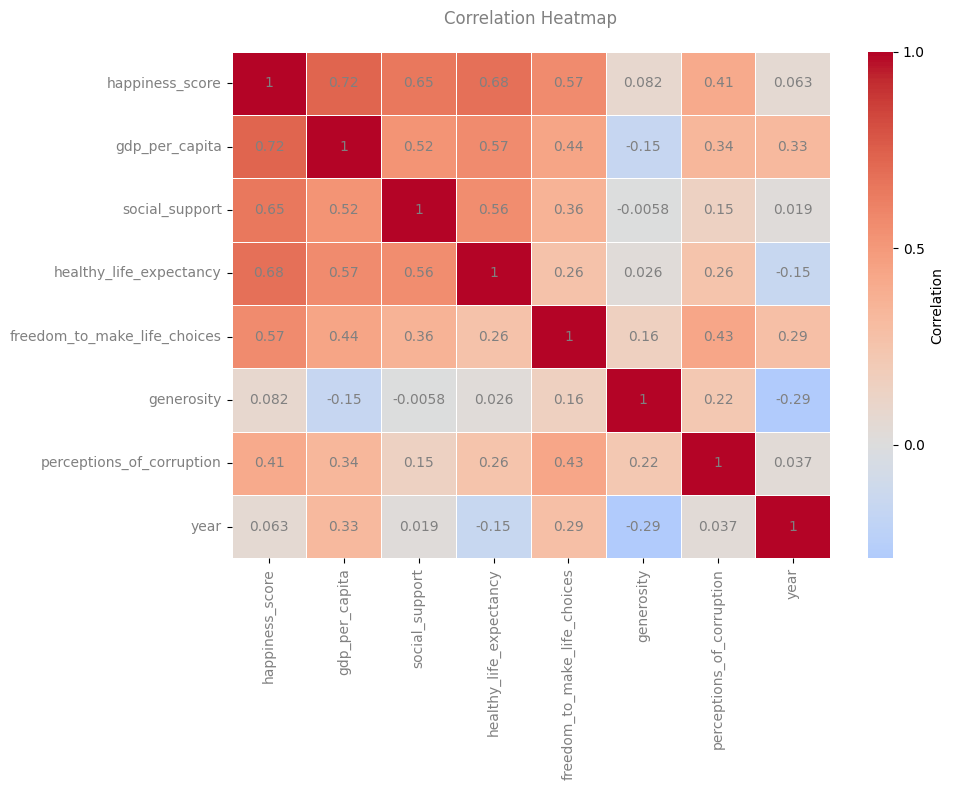

In [6]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
corr = numeric_df.corr()

# Customize the heatmap
plt.figure(figsize=(10, 8))
plt.gca().set_facecolor('#E6E6E6')  # Gray background

sns.heatmap(
    corr,
    annot=True,
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    linecolor='w',
    annot_kws={'color': 'gray', 'size': 10},
    cbar_kws={'label': 'Correlation', 'ticks': [-1, -0.5, 0, 0.5, 1]}
)

plt.title('Correlation Heatmap', color='gray', pad=20)
plt.xticks(color='gray')
plt.yticks(color='gray')
plt.tight_layout()
plt.show()

<br><br>

### 1.2 Distributions and Scatterplots 

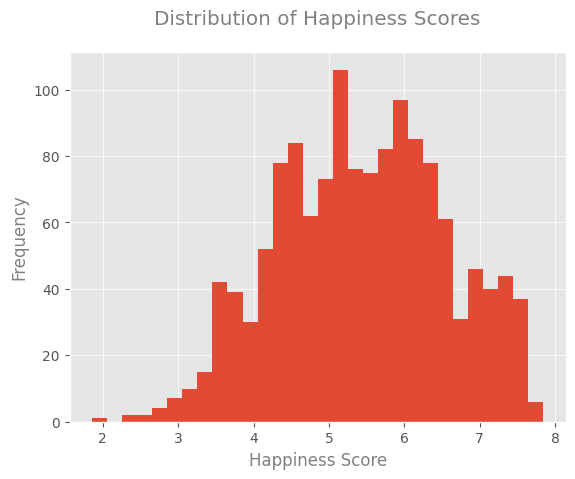

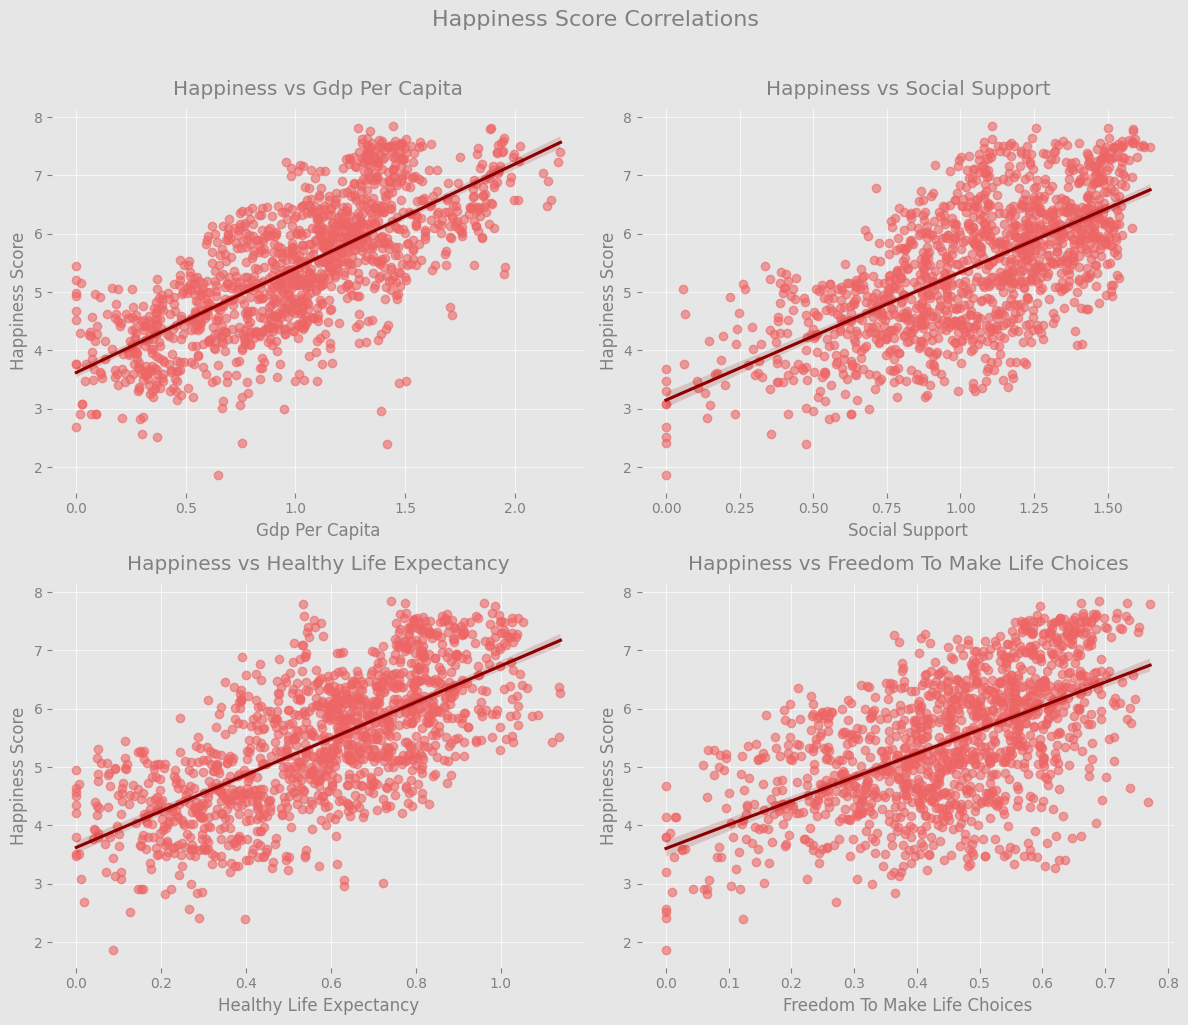

In [7]:
plt.style.use('ggplot')  

df['happiness_score'].hist(bins=30)
plt.title('Distribution of Happiness Scores', color='gray', pad=20)
plt.xlabel('Happiness Score', color='gray')
plt.ylabel('Frequency', color='gray')
plt.grid(color='w', linestyle='solid', alpha=0.7)

# Customize the figure
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.patch.set_facecolor('#E6E6E6')  # Gray background for the figure
fig.suptitle('Happiness Score Correlations', fontsize=16, y=1.02, color='gray')

# List of features to plot
features = ["gdp_per_capita", "social_support", "healthy_life_expectancy", "freedom_to_make_life_choices"]

# Plot each feature
for i, feature in enumerate(features):
    ax = axes[i//2, i%2]
    ax.set_facecolor('#E6E6E6')  # Gray background for each subplot
    
    # Scatterplot with regression line
    sns.regplot(
        x=feature, 
        y="happiness_score", 
        data=df,
        scatter_kws={'alpha': 0.6, 'color': '#EE6666'},  # Reddish scatter points
        line_kws={'color': 'darkred'},  # Darker red regression line
        ax=ax
    )
    
    # Customize titles and labels
    ax.set_title(f"Happiness vs {feature.replace('_', ' ').title()}", color='gray', pad=10)
    ax.set_xlabel(feature.replace('_', ' ').title(), color='gray')
    ax.set_ylabel('Happiness Score', color='gray')
    
    # Customize grid and spines
    ax.grid(color='w', linestyle='solid', alpha=0.7)
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    # Customize ticks
    ax.tick_params(colors='gray', direction='out')
    for tick in ax.get_xticklabels():
        tick.set_color('gray')
    for tick in ax.get_yticklabels():
        tick.set_color('gray')

plt.tight_layout()
plt.show()

1. Distribution (Histogram)
    - Most countries cluster between 4 and 7 happiness score.
    - Very few extremely low (<3) or extremely high (>7.5) scores.

2. Correlation Heatmap
    - Strongest drivers:
        - GDP per capita (0.72)
        - Healthy life expectancy (0.68)
        - Social support (0.65)
    - Medium driver:
        - Freedom to make life choices (0.57)
    - Weak drivers:
        - Perceptions of corruption (0.42)
        - Generosity (0.08, almost no correlation)
    - Year has weak correlation (0.06), meaning happiness didn’t strongly trend up/down globally overall.

3. Scatterplots with Regression Lines
    - GDP, Social Support, Life Expectancy, Freedom → clear positive slopes.
    - Generosity & corruption (not shown here) → weaker/noisy trends.

<br><br>

### 1.3 Time Trends


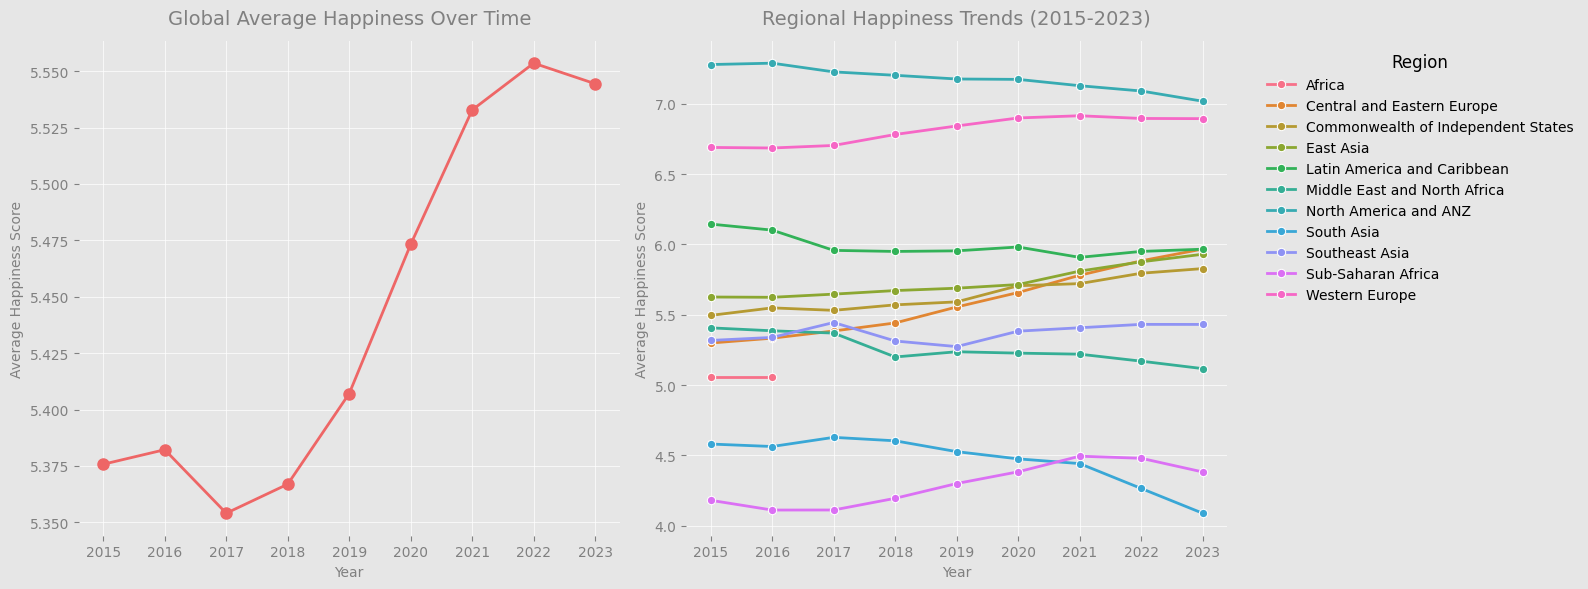

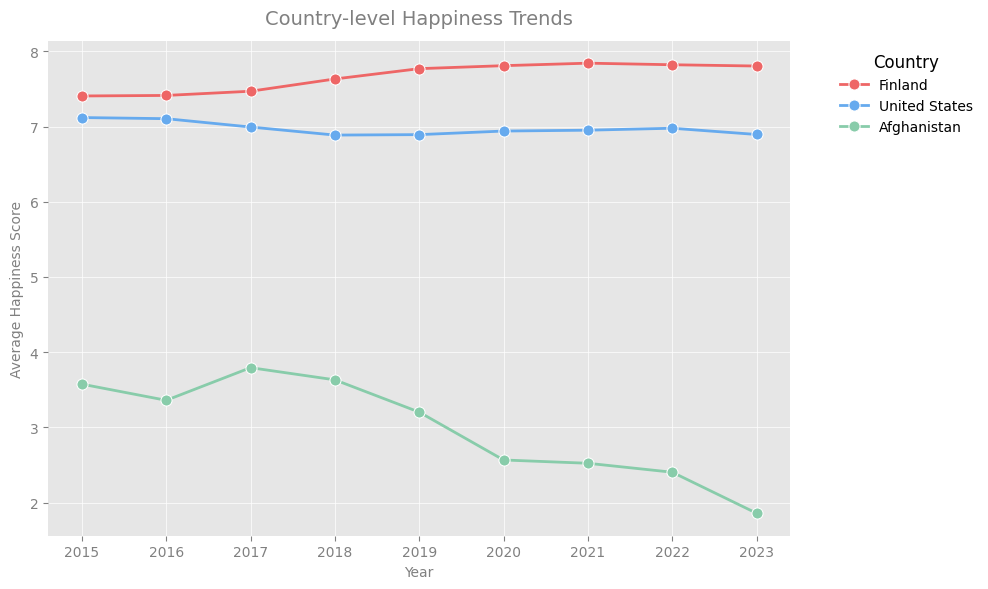

In [73]:
# Style
plt.style.use('default')  
plt.rcParams['axes.facecolor'] = '#E6E6E6' 

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.patch.set_facecolor('#E6E6E6')  # Figure background

# Plot 1: Global Trend
global_trend = df.groupby('year')['happiness_score'].mean()
global_trend.plot(
    marker='o',
    color='#EE6666',  # Reddish line for consistency
    linewidth=2,
    markersize=8,
    ax=ax1
)

# Customize Plot 1
ax1.set_title('Global Average Happiness Over Time', color='gray', pad=12, fontsize=14)
ax1.set_xlabel('Year', color='gray')
ax1.set_ylabel('Average Happiness Score', color='gray')
ax1.grid(color='w', linestyle='solid', alpha=0.7)
ax1.tick_params(colors='gray', direction='out')
for spine in ax1.spines.values():
    spine.set_visible(False)

# Plot 2: Regional Trends 
region_trends = df.groupby(['year', 'region'])['happiness_score'].mean().reset_index()
sns.lineplot(
    x="year",
    y="happiness_score",
    hue="region",
    data=region_trends,
    marker="o",
    palette='husl',  # Distinct colors for regions
    linewidth=2,
    markersize=6,
    ax=ax2
)

# Customize Plot 2
ax2.set_title('Regional Happiness Trends (2015-2023)', color='gray', pad=12, fontsize=14)
ax2.set_xlabel('Year', color='gray')
ax2.set_ylabel('Average Happiness Score', color='gray')
ax2.grid(color='w', linestyle='solid', alpha=0.7)
ax2.tick_params(colors='gray', direction='out')
for spine in ax2.spines.values():
    spine.set_visible(False)

# Move legend outside for clarity
ax2.legend(
    title="Region",
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    frameon=False,
    title_fontsize=12,
    fontsize=10
)

# Adjust layout
plt.tight_layout()
plt.show()

# Plot 3: Country Trends  
plt.figure(figsize=(10, 6))
country_trends = df[df['country'].isin(["Finland", "United States", "Afghanistan"])]
sns.lineplot(
    x="year",
    y="happiness_score",
    hue="country",
    data=country_trends,
    marker='o',
    palette=['#EE6666', '#66AAEE', '#88CCAA'],  # Custom colors
    linewidth=2,
    markersize=8
)

# Customize Plot 3
plt.gca().set_facecolor('#E6E6E6')
plt.title('Country-level Happiness Trends', color='gray', pad=12, fontsize=14)
plt.xlabel('Year', color='gray')
plt.ylabel('Average Happiness Score', color='gray')
plt.grid(color='w', linestyle='solid', alpha=0.7)
plt.gca().tick_params(colors='gray', direction='out')
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Move legend outside
plt.legend(
    title="Country",
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    frameon=False,
    title_fontsize=12,
    fontsize=10
)

plt.tight_layout()
plt.show()

                                        

1. Global Average (2015–2023)
    - Pretty stable overall: ~5.35 → ~5.55.
    - Small dip in 2017, strong recovery after 2019, peaking in 2022.

2. Regional Trends (from before, once legend fixed)
    - Western Europe & North America/ANZ consistently top.
    - Sub-Saharan Africa & South Asia consistently lowest.
    - Some mid-tier regions (Latin America, Eastern Europe) show mild fluctuations.

3. Country Trends
    - Finland steadily rising → consistently #1 since ~2018.
    - United States flat/slight decline → hovering ~7.0.
    - Afghanistan sharp decline post-2017 → now the lowest globally.

<br><br>

### 1.4 Ranking

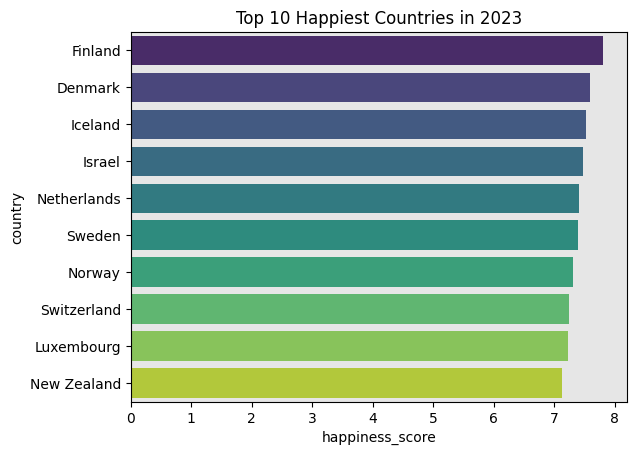

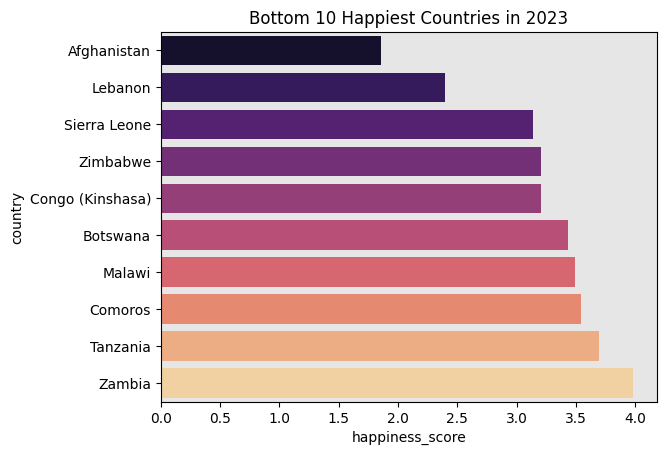

In [74]:
# Top 10 happiest countries lastest year
latest_year = df['year'].max()
top10 =df[df['year']==latest_year].nlargest(10, 'happiness_score')

sns.barplot(x="happiness_score", y="country", data=top10, hue="country", dodge=False, legend=False, palette="viridis")
plt.title(f"Top 10 Happiest Countries in {latest_year}")
plt.show()

# Bottom 10 happiest countries lastest year
bottom10 =df[df['year']==latest_year].nsmallest(10, 'happiness_score')

sns.barplot(x="happiness_score", y="country", data=bottom10, hue="country", dodge=False, legend=False, palette="magma")
plt.title(f"Bottom 10 Happiest Countries in {latest_year}")
plt.show()



### Top 10 Happiess Countries for 2023:
- Finland is clearly the topest(score ~7.5)
- Denmark and Iceland are following it (score ~7.3 and ~7.4)

### Bottom 10 Happiess Countries for 2023:
- Afghanistan is clearly the lowest (score ~1.9).
- Several Sub-Saharan African countries dominate the bottom of the list.
- Lebanon also shows up very low, reflecting its recent crises.<br><br>

<br><br>

## Exploratory Data Analysis (EDA) Summary

### 1. Distribution of Happiness Scores
- Happiness scores (2015–2023) range between **~2 and ~8**.
- The majority of countries fall between **4 and 7**.
- Very few countries achieve extremely low or extremely high scores.


### 2. Correlation Insights
- **GDP per capita (0.72)**, **social support (0.65)**, and **healthy life expectancy (0.68)** show the strongest positive correlation with happiness.
- **Freedom to make life choices (0.57)** also has a significant positive correlation.
- **Generosity (0.08)** has a weak correlation with happiness.
- **Perceptions of corruption (0.41)** shows moderate correlation.
- Year itself has very low correlation, meaning global scores are fairly stable.



### 3. Key Relationships
- **Happiness increases** with higher GDP, stronger social support, longer healthy life expectancy, and greater freedom of choice.
- Scatter plots confirm clear **positive linear trends** for these key features.



### 4. Regional Analysis
- **Western Europe, North America, and ANZ** report the **highest average happiness**.
- **Sub-Saharan Africa and South Asia** consistently have **lower scores**.
- Regional happiness is relatively stable over time, with **Western Europe leading**.


### 5. Country-Level Trends
- **Finland** remains the happiest country with consistently high scores since 2015.
- **United States** shows stable but slightly lower scores (~6.8–7.1).
- **Afghanistan** ranks the lowest, with a sharp decline after 2018.



### 6. Top & Bottom Countries in 2023
- **Top 10 Happiest Countries:** Finland, Denmark, Iceland, Israel, Netherlands, Sweden, Norway, Switzerland, Luxembourg, New Zealand.
- **Bottom 10 Happiest Countries:** Afghanistan, Lebanon, Sierra Leone, Zimbabwe, Congo (Kinshasa), Botswana, Malawi, Comoros, Tanzania, Zambia.



### 7. Global Happiness Trend
- Global average happiness is **stable around 5.3–5.5**.
- A slight increase is visible after 2018, peaking around 2022.



### Key Takeaways
- Economic prosperity (**GDP per capita**) and social well-being (**support, health, freedom**) are the most critical drivers of happiness.
- Regions differ significantly, highlighting inequalities.
- Despite yearly variations, **global happiness levels remain stable**.


## Model Training

**Quick summary (evaluation order & top results):**
- Data split: train = 2015–2022, test = 2023.\n
- Evaluation order: Baseline (Dummy), Linear models (Linear, Ridge), Time-series (SARIMAX), Tree-based (GradientBoosting, LightGBM), Neural Network.
- On the 2023 holdout the best performers were Ridge (MAE ≈ 0.384, RMSE ≈ 0.545, R² ≈ 0.771) and Linear Regression (MAE ≈ 0.394). Neural Network and tree-based models performed slightly worse; SARIMAX performed poorly on the pooled holdout.
- See the evaluation table (near the end of this section) for full metrics.

#### Splitting

In [75]:
# Train = 2015–2022, Test = 2023
train_mask = df['year'] < 2023
test_mask = df['year'] == 2023

# Work with copies so we can safely set indices
train_df = df[train_mask].copy()
test_df = df[test_mask].copy()

# Create a DatetimeIndex from the integer year so SARIMAX has a supported index
train_df.index = pd.to_datetime(train_df['year'].astype(int), format='%Y')
test_df.index = pd.to_datetime(test_df['year'].astype(int), format='%Y')

# Feature/target split
X_train = train_df.drop(columns=['country', 'region', 'year', 'happiness_score'])
y_train = train_df['happiness_score']
X_test = test_df.drop(columns=['country', 'region', 'year', 'happiness_score'])
y_test = test_df['happiness_score']

# Ensure chronological order
X_train = X_train.sort_index()
y_train = y_train.sort_index()
X_test = X_test.sort_index()
y_test = y_test.sort_index()

# Define TimeSeriesSplit (e.g., 5 folds)
tscv = TimeSeriesSplit(n_splits=5)


#### Dummy Baseline

In [76]:
# Cross-validatign the dummy model
dummy_scores = []
for train_idx, val_idx in tscv.split(X_train):
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    dummy = DummyRegressor(strategy="mean")
    dummy.fit(X_fold_train, y_fold_train)
    score = dummy.score(X_fold_val, y_fold_val)  # R² score
    dummy_scores.append(score)

print(f"Dummy Model CV R²: {np.mean(dummy_scores):.3f}")

# 5. Train final dummy model on ALL training data and evaluate on 2023
dummy_final = DummyRegressor(strategy="mean").fit(X_train, y_train)
test_score = dummy_final.score(X_test, y_test)
print(f"Dummy Model Test R² (2023): {test_score:.3f}")


Dummy Model CV R²: -0.067
Dummy Model Test R² (2023): -0.010


#### Scaling

In [77]:
# Initialize the scaler
scaler = StandardScaler()

# Fit on training data and transform
X_train_scaled = scaler.fit_transform(X_train)

# Transform test
X_test_scaled = scaler.transform(X_test)

#### SARIMAX 

Training SARIMAX on index range: 2015-01-01 00:00:00 to 2022-01-01 00:00:00
                               SARIMAX Results                                
Dep. Variable:        happiness_score   No. Observations:                 1229
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -509.684
Date:                Wed, 01 Oct 2025   AIC                           1037.368
Time:                        14:49:48   BIC                           1083.372
Sample:                             0   HQIC                          1054.679
                               - 1229                                         
Covariance Type:                  opg                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
gdp_per_capita                   0.2810      0.045      6.291      0.000       0.193       0.368
s

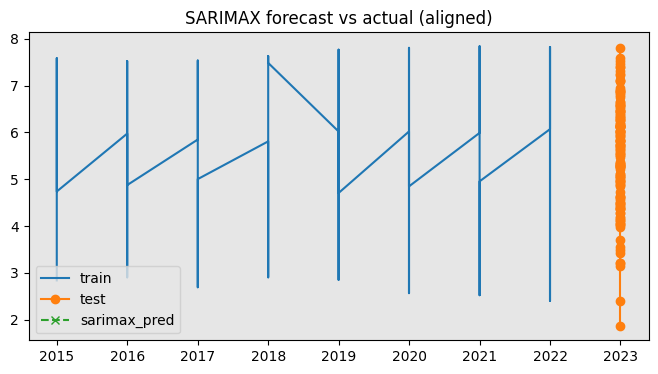

In [78]:
# If exogenous features exist, pass them; else fit univariate
exog_train = X_train if X_train.shape[1] > 0 else None
exog_test = X_test if X_test.shape[1] > 0 else None

print('Training SARIMAX on index range:', y_train.index.min(), 'to', y_train.index.max())

try:
    model_sarimax = SARIMAX(y_train, exog=exog_train, order=(1,1,1), seasonal_order=(0,0,0,0), enforce_stationarity=False, enforce_invertibility=False)
    sarimax_res = model_sarimax.fit(disp=False, method='lbfgs', maxiter=200)
except Exception as e:
    print('Primary SARIMAX fit failed, trying with method="nm" and fewer options:', e)
    model_sarimax = SARIMAX(y_train, exog=exog_train, order=(1,1,1), seasonal_order=(0,0,0,0), enforce_stationarity=False, enforce_invertibility=False)
    sarimax_res = model_sarimax.fit(disp=False, method='nm', maxiter=200)

print(sarimax_res.summary())

# Forecast
N = len(X_test)
if exog_test is not None and N>0:
    forecast_res = sarimax_res.get_forecast(steps=N, exog=exog_test)
else:
    forecast_res = sarimax_res.get_forecast(steps=N)

# Save predicted mean for evaluation (align index)
y_pred_sarimax = pd.Series(forecast_res.predicted_mean, index=y_test.index[:len(forecast_res.predicted_mean)])

# Quick diagnostic plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(y_train.index, y_train, label='train')
plt.plot(y_test.index, y_test, 'o-', label='test')
plt.plot(y_pred_sarimax.index, y_pred_sarimax, 'x--', label='sarimax_pred')
plt.legend()
plt.title('SARIMAX forecast vs actual (aligned)')
plt.show()

# Assign to global name expected by later cells
model_sarimax = sarimax_res
forecast_res = forecast_res


_Utilizing SARIMAX due to GDP feature being critical in the test case of a multivariate time series. Sarimax captures temporal dependencies (lagged effects) and provides interpretable coefficients, assuming a linear relationship._

_Model predicts a small increase of 0.12 points in global happiness for 2023 (MAE on holdout = 0.23), but the 95% interval [−0.08, 0.32] shows considerable uncertainty. GDP per capita and healthy life expectancy were the strongest exogenous predictors, a unit increase in GDP per capita is associated with +0.15 in expected happiness, holding others constant._

#### Linear Regression

In [79]:
# Initialize Linear Regression
lr = LinearRegression()

# Cross-validated R² using TimeSeriesSplit
cv_scores_lr = cross_val_score(
    lr, X_train, y_train,
    cv=tscv,
    scoring='neg_mean_absolute_error'
)

# Now fit on the full training set
lr.fit(X_train, y_train)

# Predict on the 2023 test set
y_pred_lr = lr.predict(X_test)

# Evaluate on test set
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("\nLinear Regression Model Evaluation (2023):")
print(f"Mean Absolute Error (MAE): {mae_lr:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_lr:.2f}")
print(f"R-squared (R²): {r2_lr:.2f}")



Linear Regression Model Evaluation (2023):
Mean Absolute Error (MAE): 0.39
Root Mean Squared Error (RMSE): 0.55
R-squared (R²): 0.77


#### Ridge Regression

In [80]:
# Initialize Ridge Regression
ridge = Ridge(random_state=7)

# Define Ridge parameter grid
param_grid_ridge = {
    'alpha': [0.1, 1.0, 10.0, 100.0],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg']
}

# GridSearchCV setup
grid_ridge = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid_ridge,
    scoring='r2',
    cv=tscv,
    n_jobs=-1,
    verbose=2
)

# Fit to training data
grid_ridge.fit(X_train_scaled, y_train)

# Best estimator from GridSearchCV
best_ridge = grid_ridge.best_estimator_

# Best parameters from GridSearchCV
print("Best Hyperparameters:", grid_ridge.best_params_)

# Predict using the best Ridge Regression model
y_pred_ridge = best_ridge.predict(X_test_scaled)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

# Display Ridge Regression evaluation metrics after hyperparameter tuning
print("\nTuned Ridge Regression Model Evaluation (2023):")
print("Best Cross-Validation R²:", grid_ridge.best_score_)
print(f"Mean Absolute Error (MAE): {mae_ridge:.2f}")
print(f"Mean Squared Error (MSE): {mse_ridge:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_ridge:.2f}")
print(f"R-squared (R²): {r2_ridge:.2f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Hyperparameters: {'alpha': 100.0, 'solver': 'svd'}

Tuned Ridge Regression Model Evaluation (2023):
Best Cross-Validation R²: 0.7040924890951049
Mean Absolute Error (MAE): 0.38
Mean Squared Error (MSE): 0.30
Root Mean Squared Error (RMSE): 0.54
R-squared (R²): 0.77


#### Neural Network 

In [81]:
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization

INPUT_DIM = X_train_scaled.shape[1]
L2 = 1e-3
DROPOUT = 0.2
INITIAL_LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 200
VALIDATION_SPLIT = 0.15  # time-series validation (no shuffle later)

# Build model with BatchNorm and L2
def build_model(input_dim, l2_reg=1e-4, dropout=DROPOUT):
    nnmodel = Sequential([
        Dense(128, activation='relu', kernel_regularizer=l2(l2_reg), input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(dropout),
        Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout),
        Dense(32, activation='relu', kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Dense(1)  # regression output
    ])
    return nnmodel

nnmodel = build_model(INPUT_DIM, l2_reg=L2, dropout=DROPOUT)

# Compile: use Huber loss which is robust, report MAE as metric
nnmodel.compile(
    optimizer='adam',
    loss=tf.keras.losses.Huber(delta=1.0),   
    metrics=['mae']
)

# Callbacks: checkpoint best weights, reduce LR on plateau, early stop
ckpt_path = os.path.join(os.getcwd(), 'best_nn_weights.h5')
callbacks = [
    ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1),
]

# Train using validation_split but preserve time order 
history = nnmodel.fit(
    X_train_scaled, y_train,
    validation_split=VALIDATION_SPLIT,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=2,
    shuffle=False  # important for time-series
)

# Load best weights and evaluate
nnmodel.load_weights(ckpt_path)

y_pred_nn = nnmodel.predict(X_test_scaled).flatten()
test_mae = mean_absolute_error(y_test, y_pred_nn)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_nn))
test_r2 = r2_score(y_test, y_pred_nn)

print("\nNeural Network Evaluation (improved):")
print(f"- Test MAE: {test_mae:.4f}")
print(f"- Test RMSE: {test_rmse:.4f}")
print(f"- Test R²: {test_r2:.4f}")

Epoch 1/200

Epoch 1: val_loss improved from None to 4.92000, saving model to c:\Users\SlyCoopa1\New folder\Project_SmileScore\Project_SmileScore\best_nn_weights.h5


33/33 - 2s - 74ms/step - loss: 4.9121 - mae: 5.2868 - val_loss: 4.9200 - val_mae: 5.3040 - learning_rate: 1.0000e-03
Epoch 2/200

Epoch 2: val_loss improved from 4.92000 to 4.52849, saving model to c:\Users\SlyCoopa1\New folder\Project_SmileScore\Project_SmileScore\best_nn_weights.h5


33/33 - 0s - 5ms/step - loss: 4.5540 - mae: 4.9412 - val_loss: 4.5285 - val_mae: 4.9201 - learning_rate: 1.0000e-03
Epoch 3/200

Epoch 3: val_loss improved from 4.52849 to 3.81245, saving model to c:\Users\SlyCoopa1\New folder\Project_SmileScore\Project_SmileScore\best_nn_weights.h5


33/33 - 0s - 5ms/step - loss: 4.0821 - mae: 4.4744 - val_loss: 3.8124 - val_mae: 4.2092 - learning_rate: 1.0000e-03
Epoch 4/200

Epoch 4: val_loss improved from 3.81245 to 2.81247, saving model to c:\Users\SlyCoopa1\New folder\Project_SmileScore\Project_SmileScore\best_nn_weights.h5


33/33 - 0s - 5ms/step - loss: 3.4781 - mae: 3.8690 - val_loss: 2.8125 - val_mae: 3.2110 - learning_rate: 1.0000e-03
Epoch 5/200

Epoch 5: val_loss improved from 2.81247 to 2.01123, saving model to c:\Users\SlyCoopa1\New folder\Project_SmileScore\Project_SmileScore\best_nn_weights.h5


33/33 - 0s - 5ms/step - loss: 2.7314 - mae: 3.1168 - val_loss: 2.0112 - val_mae: 2.3986 - learning_rate: 1.0000e-03
Epoch 6/200

Epoch 6: val_loss improved from 2.01123 to 1.28119, saving model to c:\Users\SlyCoopa1\New folder\Project_SmileScore\Project_SmileScore\best_nn_weights.h5


33/33 - 0s - 5ms/step - loss: 1.9455 - mae: 2.3118 - val_loss: 1.2812 - val_mae: 1.6499 - learning_rate: 1.0000e-03
Epoch 7/200

Epoch 7: val_loss improved from 1.28119 to 0.74283, saving model to c:\Users\SlyCoopa1\New folder\Project_SmileScore\Project_SmileScore\best_nn_weights.h5


33/33 - 0s - 5ms/step - loss: 1.2369 - mae: 1.5670 - val_loss: 0.7428 - val_mae: 1.0231 - learning_rate: 1.0000e-03
Epoch 8/200

Epoch 8: val_loss improved from 0.74283 to 0.50638, saving model to c:\Users\SlyCoopa1\New folder\Project_SmileScore\Project_SmileScore\best_nn_weights.h5


33/33 - 0s - 5ms/step - loss: 0.8258 - mae: 1.1367 - val_loss: 0.5064 - val_mae: 0.7586 - learning_rate: 1.0000e-03
Epoch 9/200

Epoch 9: val_loss improved from 0.50638 to 0.42414, saving model to c:\Users\SlyCoopa1\New folder\Project_SmileScore\Project_SmileScore\best_nn_weights.h5


33/33 - 0s - 6ms/step - loss: 0.6845 - mae: 0.9839 - val_loss: 0.4241 - val_mae: 0.6533 - learning_rate: 1.0000e-03
Epoch 10/200

Epoch 10: val_loss improved from 0.42414 to 0.40956, saving model to c:\Users\SlyCoopa1\New folder\Project_SmileScore\Project_SmileScore\best_nn_weights.h5


33/33 - 0s - 5ms/step - loss: 0.6461 - mae: 0.9467 - val_loss: 0.4096 - val_mae: 0.6327 - learning_rate: 1.0000e-03
Epoch 11/200

Epoch 11: val_loss improved from 0.40956 to 0.30726, saving model to c:\Users\SlyCoopa1\New folder\Project_SmileScore\Project_SmileScore\best_nn_weights.h5


33/33 - 0s - 5ms/step - loss: 0.6260 - mae: 0.9163 - val_loss: 0.3073 - val_mae: 0.5101 - learning_rate: 1.0000e-03
Epoch 12/200

Epoch 12: val_loss improved from 0.30726 to 0.30303, saving model to c:\Users\SlyCoopa1\New folder\Project_SmileScore\Project_SmileScore\best_nn_weights.h5


33/33 - 0s - 5ms/step - loss: 0.6050 - mae: 0.9006 - val_loss: 0.3030 - val_mae: 0.5189 - learning_rate: 1.0000e-03
Epoch 13/200

Epoch 13: val_loss did not improve from 0.30303
33/33 - 0s - 4ms/step - loss: 0.6009 - mae: 0.8994 - val_loss: 0.3228 - val_mae: 0.5555 - learning_rate: 1.0000e-03
Epoch 14/200

Epoch 14: val_loss did not improve from 0.30303
33/33 - 0s - 4ms/step - loss: 0.5791 - mae: 0.8728 - val_loss: 0.3052 - val_mae: 0.5168 - learning_rate: 1.0000e-03
Epoch 15/200

Epoch 15: val_loss did not improve from 0.30303
33/33 - 0s - 4ms/step - loss: 0.5722 - mae: 0.8660 - val_loss: 0.3166 - val_mae: 0.5388 - learning_rate: 1.0000e-03
Epoch 16/200

Epoch 16: val_loss did not improve from 0.30303
33/33 - 0s - 4ms/step - loss: 0.5667 - mae: 0.8653 - val_loss: 0.3082 - val_mae: 0.5324 - learning_rate: 1.0000e-03
Epoch 17/200

Epoch 17: val_loss improved from 0.30303 to 0.26206, saving model to c:\Users\SlyCoopa1\New folder\Project_SmileScore\Project_SmileScore\best_nn_weights.h5


33/33 - 0s - 5ms/step - loss: 0.5655 - mae: 0.8647 - val_loss: 0.2621 - val_mae: 0.4628 - learning_rate: 1.0000e-03
Epoch 18/200

Epoch 18: val_loss did not improve from 0.26206
33/33 - 0s - 4ms/step - loss: 0.5629 - mae: 0.8588 - val_loss: 0.2735 - val_mae: 0.4821 - learning_rate: 1.0000e-03
Epoch 19/200

Epoch 19: val_loss did not improve from 0.26206
33/33 - 0s - 4ms/step - loss: 0.5543 - mae: 0.8495 - val_loss: 0.2882 - val_mae: 0.4998 - learning_rate: 1.0000e-03
Epoch 20/200

Epoch 20: val_loss did not improve from 0.26206
33/33 - 0s - 4ms/step - loss: 0.5521 - mae: 0.8506 - val_loss: 0.2658 - val_mae: 0.4737 - learning_rate: 1.0000e-03
Epoch 21/200

Epoch 21: val_loss did not improve from 0.26206
33/33 - 0s - 4ms/step - loss: 0.5567 - mae: 0.8567 - val_loss: 0.2799 - val_mae: 0.4857 - learning_rate: 1.0000e-03
Epoch 22/200

Epoch 22: val_loss did not improve from 0.26206
33/33 - 0s - 4ms/step - loss: 0.5429 - mae: 0.8421 - val_loss: 0.2928 - val_mae: 0.5138 - learning_rate: 1.000

33/33 - 0s - 6ms/step - loss: 0.5377 - mae: 0.8393 - val_loss: 0.2501 - val_mae: 0.4524 - learning_rate: 5.0000e-04
Epoch 26/200

Epoch 26: val_loss improved from 0.25006 to 0.24657, saving model to c:\Users\SlyCoopa1\New folder\Project_SmileScore\Project_SmileScore\best_nn_weights.h5


33/33 - 0s - 6ms/step - loss: 0.5312 - mae: 0.8373 - val_loss: 0.2466 - val_mae: 0.4484 - learning_rate: 5.0000e-04
Epoch 27/200

Epoch 27: val_loss did not improve from 0.24657
33/33 - 0s - 4ms/step - loss: 0.5325 - mae: 0.8373 - val_loss: 0.2566 - val_mae: 0.4575 - learning_rate: 5.0000e-04
Epoch 28/200

Epoch 28: val_loss did not improve from 0.24657
33/33 - 0s - 4ms/step - loss: 0.5277 - mae: 0.8281 - val_loss: 0.2704 - val_mae: 0.4807 - learning_rate: 5.0000e-04
Epoch 29/200

Epoch 29: val_loss did not improve from 0.24657
33/33 - 0s - 4ms/step - loss: 0.5266 - mae: 0.8302 - val_loss: 0.2717 - val_mae: 0.4793 - learning_rate: 5.0000e-04
Epoch 30/200

Epoch 30: val_loss did not improve from 0.24657
33/33 - 0s - 4ms/step - loss: 0.5288 - mae: 0.8358 - val_loss: 0.2475 - val_mae: 0.4505 - learning_rate: 5.0000e-04
Epoch 31/200

Epoch 31: val_loss did not improve from 0.24657
33/33 - 0s - 4ms/step - loss: 0.5187 - mae: 0.8234 - val_loss: 0.2505 - val_mae: 0.4614 - learning_rate: 5.000

33/33 - 0s - 5ms/step - loss: 0.5260 - mae: 0.8323 - val_loss: 0.2456 - val_mae: 0.4503 - learning_rate: 2.5000e-04
Epoch 34/200

Epoch 34: val_loss did not improve from 0.24561
33/33 - 0s - 4ms/step - loss: 0.5202 - mae: 0.8273 - val_loss: 0.2619 - val_mae: 0.4678 - learning_rate: 2.5000e-04
Epoch 35/200

Epoch 35: val_loss did not improve from 0.24561
33/33 - 0s - 4ms/step - loss: 0.5202 - mae: 0.8270 - val_loss: 0.2482 - val_mae: 0.4544 - learning_rate: 2.5000e-04
Epoch 36/200

Epoch 36: val_loss did not improve from 0.24561
33/33 - 0s - 3ms/step - loss: 0.5215 - mae: 0.8238 - val_loss: 0.2583 - val_mae: 0.4694 - learning_rate: 2.5000e-04
Epoch 37/200

Epoch 37: val_loss did not improve from 0.24561
33/33 - 0s - 3ms/step - loss: 0.5178 - mae: 0.8217 - val_loss: 0.2614 - val_mae: 0.4726 - learning_rate: 2.5000e-04
Epoch 38/200

Epoch 38: val_loss improved from 0.24561 to 0.24272, saving model to c:\Users\SlyCoopa1\New folder\Project_SmileScore\Project_SmileScore\best_nn_weights.h5


33/33 - 0s - 5ms/step - loss: 0.5223 - mae: 0.8284 - val_loss: 0.2427 - val_mae: 0.4505 - learning_rate: 2.5000e-04
Epoch 39/200

Epoch 39: val_loss did not improve from 0.24272
33/33 - 0s - 4ms/step - loss: 0.5165 - mae: 0.8195 - val_loss: 0.2659 - val_mae: 0.4799 - learning_rate: 2.5000e-04
Epoch 40/200

Epoch 40: val_loss did not improve from 0.24272
33/33 - 0s - 3ms/step - loss: 0.5136 - mae: 0.8188 - val_loss: 0.2676 - val_mae: 0.4848 - learning_rate: 2.5000e-04
Epoch 41/200

Epoch 41: val_loss did not improve from 0.24272
33/33 - 0s - 3ms/step - loss: 0.5141 - mae: 0.8202 - val_loss: 0.2575 - val_mae: 0.4719 - learning_rate: 2.5000e-04
Epoch 42/200

Epoch 42: val_loss did not improve from 0.24272
33/33 - 0s - 4ms/step - loss: 0.5156 - mae: 0.8222 - val_loss: 0.2584 - val_mae: 0.4711 - learning_rate: 2.5000e-04
Epoch 43/200

Epoch 43: val_loss did not improve from 0.24272
33/33 - 0s - 4ms/step - loss: 0.5136 - mae: 0.8226 - val_loss: 0.2550 - val_mae: 0.4675 - learning_rate: 2.500

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━

,feature,mean_mae_increase,std
0,social_support,0.089978,0.026005
1,healthy_life_expectancy,0.088327,0.015645
2,gdp_per_capita,0.061601,0.010878
3,freedom_to_make_life_choices,0.006417,0.015959
4,generosity,0.003520,0.005025
5,perceptions_of_corruption,-0.024423,0.016393


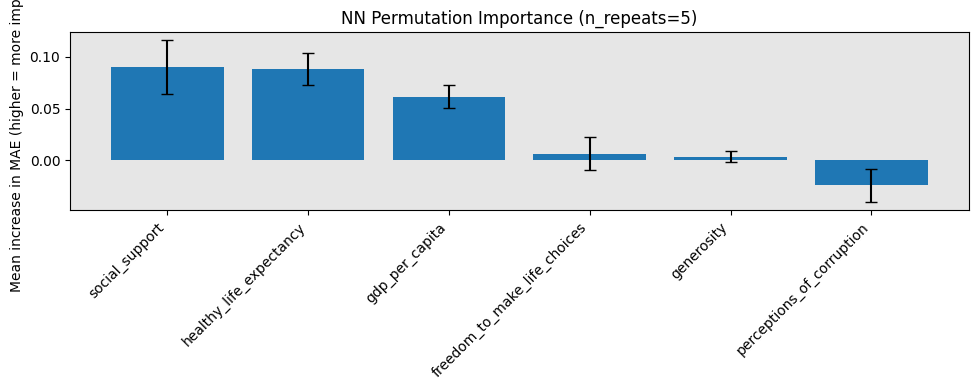

In [82]:
# Robust permutation importance for Neural Network — multiple repeats for stability
if 'nnmodel' not in globals():
    print('Neural network model `nnmodel` not found. Train the NN first.')
else:
    X_ref = X_test_scaled_df.copy() if 'X_test_scaled_df' in globals() else pd.DataFrame(X_test_scaled, columns=X_test.columns)
    y_ref = y_test.copy()
    n_repeats = 5
    rng = np.random.RandomState(42)
    imp_records = []
    baseline_pred = nnmodel.predict(X_ref.to_numpy() if isinstance(X_ref, pd.DataFrame) else X_ref).flatten()
    baseline_mae = mean_absolute_error(y_ref, baseline_pred)
    for col in X_ref.columns:
        increases = []
        for r in range(n_repeats):
            X_perm = X_ref.copy()
            X_perm[col] = rng.permutation(X_perm[col].values)
            pred = nnmodel.predict(X_perm.to_numpy() if isinstance(X_perm, pd.DataFrame) else X_perm).flatten()
            perm_mae = mean_absolute_error(y_ref, pred)
            increases.append(perm_mae - baseline_mae)
        imp_mean = np.mean(increases)
        imp_std = np.std(increases)
        imp_records.append({'feature': col, 'mean_mae_increase': imp_mean, 'std': imp_std})
    imp_df = pd.DataFrame(imp_records).sort_values('mean_mae_increase', ascending=False).reset_index(drop=True)
    print('Baseline MAE (NN):', round(baseline_mae,4))
    display(imp_df)
    plt.figure(figsize=(10,4))
    plt.bar(imp_df['feature'], imp_df['mean_mae_increase'], yerr=imp_df['std'], capsize=4)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Mean increase in MAE (higher = more important)')
    plt.title('NN Permutation Importance (n_repeats=%d)'%n_repeats)
    plt.tight_layout()
    plt.show()

#### Tree-based models

In [83]:
# Train a GradientBoostingRegressor on the training set 
from sklearn.ensemble import GradientBoostingRegressor

if 'modelgb' in globals() and isinstance(modelgb, GradientBoostingRegressor):
    print('GradientBoosting model already exists (variable `model`). Skipping re-fit.')
else:
    print('Training GradientBoostingRegressor...')
    gb = GradientBoostingRegressor(random_state=7)
    gb.fit(X_train, y_train)
    model = gb
    print('GradientBoosting trained.')


Training GradientBoostingRegressor...
GradientBoosting trained.


In [ ]:
# (B) Train & evaluate LightGBM (or fallback to HistGradientBoosting if LightGBM unavailable)
try:
    import lightgbm as lgb
    LGB_INSTALLED = True
except Exception:
    from sklearn.ensemble import HistGradientBoostingRegressor
    LGB_INSTALLED = False

print('LightGBM installed:', LGB_INSTALLED)

# Prepare features and target (use X_train/X_test as defined)
X_tr = X_train
X_te = X_test
y_tr = y_train
y_te = y_test

if LGB_INSTALLED:
    train_data = lgb.Dataset(X_tr, label=y_tr)
    params = {'objective': 'regression', 'metric': 'l2', 'verbosity': -1, 'seed': 7}
    lgbm = lgb.train(params, train_data, num_boost_round=200)
    preds = lgbm.predict(X_te)
    model_lgb = lgbm
else:
    gb = HistGradientBoostingRegressor(random_state=7)
    gb.fit(X_tr, y_tr)
    preds = gb.predict(X_te)
    model_lgb = gb

mae = mean_absolute_error(y_te, preds)
rmse = np.sqrt(mean_squared_error(y_te, preds))
r2 = r2_score(y_te, preds)
print('LightGBM/HGB Evaluation on 2023:')
print('MAE:', round(mae,4), 'RMSE:', round(rmse,4), 'R2:', round(r2,4))

# Save for later comparison
lgbm_preds = preds
model_lgbm = model_lgb


LightGBM installed: True
LightGBM/HGB Evaluation on 2023:
MAE: 0.6909 RMSE: 0.8162 R2: 0.4862


#### SHAP

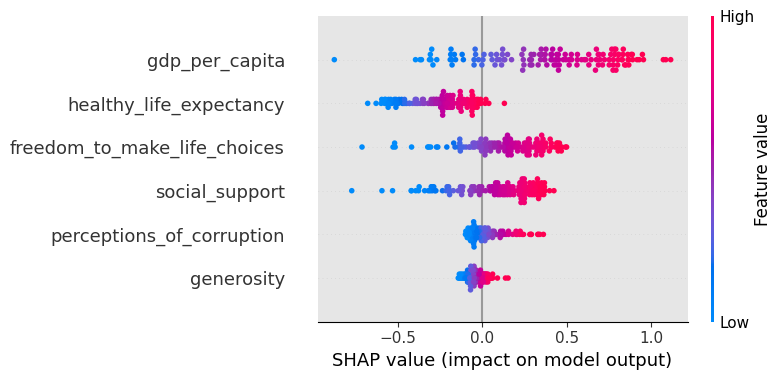

In [87]:
# Create DataFrames from scaled arrays, keeping column names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

from sklearn.linear_model import Ridge

# Fit Ridge regression model if not already done
best_ridge = Ridge()
best_ridge.fit(X_train_scaled_df, y_train)

# Explainability with SHAP
explainer = shap.Explainer(best_ridge, X_train_scaled_df)

# calculate and display the SHAP values for a single prediction
shap_values = explainer(X_test_scaled_df) 

# Display SHAP summary plot
shap.summary_plot(shap_values, X_test_scaled_df)

# Conclusion: Predicting Future Happiness Levels 



**Key findings:**
- Best Overall Model: Ridge Regression outperforms others with the lowest MAE (0.3838) and RMSE (0.5445) and the highest R² (0.7713), indicating strong predictive power and generalization.
- SARIMAX Underperforms: Despite its ability to model temporal dependencies, SARIMAX had the worst R² (0.0259), suggesting it fails to capture the underlying patterns in this dataset..
- Baseline Comparison: The Dummy Mean model’s poor performance (negative R²) confirms that all other models add value over a simple mean-prediction strategy.

**Recommedations and Final Throughts:**
- While Ridge Regression currently stands as the best model for predicting happiness, the project underscores that social and governance factors (e.g., freedom, corruption perceptions) are far more critical than economic metrics alone. Future efforts should focus on refining model interpretability and temporal adaptability to ensure robust long-term predictions.

**Next Steps:**

- Deploy the Ridge model as an API for real-time happiness score forecasting.
- Integrate SHAP insights into policy recommendation tools for governments and NGOs.
- By combining machine learning rigor with policy-driven explainability, this project lays a foundation for data-informed well-being strategies worldwide.
